In [1]:
import UNETLibrary
from ImageGen import *
from UNETLibrary import *

## Prepare the image files for readable format

In [2]:
# getting filenames
f = open("./ModelTrainingData/TileIds.txt")
x_train_filenames = []
y_train_filenames = []
DATE = '2019-08-09'
# each mask has 3 inputs, namely tci, ndvi and fci
for id in f:
    id = str(id).replace("\n","")
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "tci-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "ndvi-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "fci-mode1-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))

# splitting into train/val set 
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, 
                                     test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(y_val_filenames)
print("There are {} training inputs.".format(num_train_examples))
print("There are {} validation labels.".format(num_val_examples))
print(x_train_filenames[:4])
print(y_train_filenames[:4])    

There are 156 training inputs.
There are 39 validation labels.
['./ModelTrainingData/input/fci-mode1-1536-1536-2019-08-09.png', './ModelTrainingData/input/tci-6656-7168-2019-08-09.png', './ModelTrainingData/input/fci-mode1-6656-4608-2019-08-09.png', './ModelTrainingData/input/fci-mode1-7168-5632-2019-08-09.png']
['./ModelTrainingData/label/mask-1536-1536.png', './ModelTrainingData/label/mask-6656-7168.png', './ModelTrainingData/label/mask-6656-4608.png', './ModelTrainingData/label/mask-7168-5632.png']


(512, 512, 3) (511, 511) (511, 511, 1)


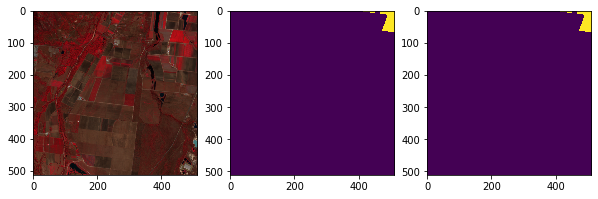

<tf.Tensor 'ExpandDims:0' shape=(511, 511, 1, 1) dtype=uint16>

In [3]:
# reading one file and see  
fname=x_train_filenames[0]
label_path = y_train_filenames[0]

# decoding images 
img_str = tf.read_file(fname)
img = tf.image.decode_png(img_str, channels=3)
label_str=tf.read_file(label_path)
label_de=tf.image.decode_png(label_str,channels=1,dtype=tf.dtypes.uint16)
  
# differnt method to open image just to check 
label_img = Image.open(label_path)


with tf.Session() as sess:
    img = sess.run(img)
    label_de = sess.run(label_de)
    
    print(img.shape, label_img.size, label_de.shape)

    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.imshow(label_img)
    
    plt.subplot(1, 3, 3)
    plt.imshow(label_de[:,:,0])
    
    plt.show()

# add one more dimemsion, but we don't need sine already in 3 dimemsion
tf.expand_dims(label_de, axis=-1)

## Set up image augmentation


In [4]:
# apply image augmentation to training set but not validation set 
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0,
    'height_shift_range': 0
} # passing augment parameters
tr_preprocessing_fn = functools.partial(UNETLibrary._augment, **tr_cfg)  



val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(UNETLibrary._augment, **val_cfg)

# creating dataset using augmentation
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

W0926 10:22:35.342921 4457428416 deprecation_wrapper.py:119] From /Users/yuanwenliang/Documents/GitHubRepos/datathon-mel/datathon/data-process/UNETLibrary.py:27: The name tf.read_file is deprecated. Please use tf.io.read_file instead.

W0926 10:22:35.367439 4457428416 deprecation_wrapper.py:119] From /Users/yuanwenliang/Documents/GitHubRepos/datathon-mel/datathon/data-process/UNETLibrary.py:77: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

W0926 10:22:35.390774 4457428416 deprecation_wrapper.py:119] From /Users/yuanwenliang/Documents/GitHubRepos/datathon-mel/datathon/data-process/UNETLibrary.py:58: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 10:22:35.441661 4457428416 deprecation.py:323] From /Users/yuanwenliang/Documents/GitHubRepos/datathon-mel/datathon/data-process/UNETLibrary.py:85: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for up

(512, 512, 3) (1, 512, 512, 1) 10.508114


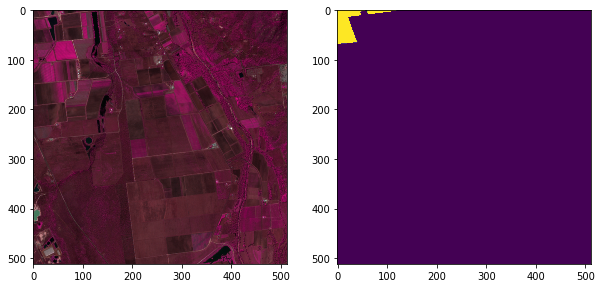

In [7]:
# let's see does the augmentation work
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]
    print(img.shape, label.shape, np.sum(label[0,:,:,0]))

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0])
    plt.show()

## UNET model

In [8]:
# UNET model
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)


W0926 10:23:15.834548 4457428416 deprecation.py:506] From /anaconda3/envs/mlsa/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [10]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

W0926 10:23:18.881855 4457428416 deprecation.py:323] From /anaconda3/envs/mlsa/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
save_model_path = './models/UNET.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, 
                                        monitor='val_dice_loss', 
                                        save_best_only=True, verbose=1)

In [24]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

KeyboardInterrupt: 